In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm



# Ler os dados do arquivo CSV
file_path = '/content/Transitent_gem_modified.txt'  # Caminho para o arquivo de dados
df = pd.read_csv(file_path,delimiter = ",")

# Definir os limites do intervalo de z (opcional)
zmin = 0
zmax = 15

zmin = zmin*1e-3
zmax = zmax*1e-3

#regiao = "GEM3 - Anodo"
df_filtered = df[(df['    z-coordinate'] >= zmin) & (df['    z-coordinate'] <= zmax)]

# Definir o tamanho da grade 2D
num_bins = 60

# Criar a matriz do histograma 2D
heatmap, xedges, yedges = np.histogram2d(df_filtered['    x-coordinate'],
                                         df_filtered['    y-coordinate'],
                                         bins=num_bins,
                                         weights=df_filtered['  total-pressure'],
                                         range=[[0,0.3],[0,0.3]])

counts, _, _ = np.histogram2d(df_filtered['    x-coordinate'], df_filtered['    y-coordinate'], bins=num_bins,range=[[0,0.3],[0,0.3]])

# Calcular a pressão média em cada bin (evitar divisão por zero)
mean_pressure = np.divide(heatmap, counts, where=counts!=0)


# Tratar os valores NaN (resultantes de bins sem contagens) substituindo por zero
mean_pressure = np.nan_to_num(mean_pressure)

for i in range(len(mean_pressure)):
  for j in range(len(mean_pressure[i])):
    mean_pressure[i][j] = (mean_pressure[i][j])

# Valor da pressão atmoférica de SP
#sp_pressure = 92340


#mean_pressure = (mean_pressure/ref)*sp_pressure


# Plotar o histograma 2D
plt.figure(figsize=(6, 6))
plt.imshow(mean_pressure.T, origin='lower', cmap='viridis', extent=(0, 0.3, 0, 0.3) )
#plt.colorbar(label='Pressão Média (Pa)')
#cbar.ax.yaxis.set_major_formatter(FuncFormatter(pressure_format))
plt.colorbar(label='Variação percentual da pressão (%)')
plt.title(f'Pressão Média em Z = {zmin*1000,zmax*1000}mm , bin = {num_bins,num_bins}',fontsize = 10)
plt.xlabel('Posição X')
plt.ylabel('Posição Y')
plt.gca().set_aspect('equal', adjustable='box')
plt.hlines(0.025, 0.025,0.275, linestyles='dashed', colors='red')
plt.hlines(0.275, 0.025,0.275, linestyles='dashed', colors='red')
plt.vlines(0.275, 0.025,0.275, linestyles='dashed', colors='red')
plt.vlines(0.025, 0.025,0.275, linestyles='dashed', colors='red')
#plt.text(0.2,0.28, regiao, color="red",fontsize = 11)
#plt.savefig("/content/" + regiao + ".png")
plt.show()


In [212]:
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def load_data(filename):
    data = pd.read_csv(filename, delimiter=',')
    data.columns = data.columns.str.strip()  #remover os espaços do arquivo
    data = data['x-coordinate'], data['y-coordinate'], data['z-coordinate'], data['x-velocity'], data['y-velocity'], data['z-velocity']
    return np.array(data).T #retorna o x,y,z,vx,vy,vz

def create_interpolator(data):
    #vou criar o interpolador pra ter o valor da velocidade em qualquer ponto
    pontos = data[:,:3]
    velocidades = data[:,3:]
    #retornar a função do interpolador para acessar dado pontos qualquer x0,y0,z0
    return interp.LinearNDInterpolator(pontos, v_field)


def streamline(interpolator, seed, t_max=100, dt=0.01):
    def velocity(t, y): #função que serve de input para o integrador RK4
      v = interpolator(y)
      #mask_nan = np.isnan(v)
      #mask_zero = (v == 0)
      #mask_nan_or_zero = mask_nan | mask_zero
      return v #if np.all(np.isfinite(v)) else np.zeros(v) #retorna o vetor velocidades se isso não for um nan ou zero

    sol = integrate.solve_ivp(velocity, [0, t_max], seed, t_eval=np.arange(0, t_max, dt), method = "RK45")
    return np.array(sol.y)

def plot_streamlines(streamlines):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax.scatter(x, y, z, s=1,color="gray", alpha=0.01)

    for streamline in streamlines:
        ax.plot(*streamline, color='b')

    plt.show()

def recreate_vel_field(interpolator, streamlines):
    contador = len(streamlines)
    i = 0
    list_streamline = []
    list_modv = []
    list_medias = []
    for streamline in streamlines:
      for pontos in (streamline.T):
        list_modv.append(np.linalg.norm(interpolator(pontos),axis=1))
      list_medias.append(np.mean(list_modv))

      i+=1
      print(f"loading... {100*i/contador:0.2}%")

    return list_medias #retorna o módulo da velocidade em cada ponto recriado do campo de velocidades

def RTD(streamlines, modv):
    #tempo de residencia é o o tamanho da streamline dividido pela velociade média
    # (15,N,3)
    tempos = []
    #calcular o tamanho da streamline com um integrador
    for streamline, v in zip(streamlines,modv):
      diff = np.diff(np.array(streamline).T,axis=0)
      distancia = np.linalg.norm(diff,axis=1)
      comprimento = np.sum(distancia)
      tempos.append(comprimento/v)

    return tempos

In [211]:
# Calcular as diferenças entre pontos consecutivos
diff = np.diff(np.array(streamlines[0]).T, axis=0)  # Diferença entre as linhas consecutivas

# Calcular a norma (distância euclidiana) de cada vetor de diferença
distances = np.linalg.norm(diff, axis=1)

# Calcular o comprimento total somando as distâncias
L = np.sum(distances)
print(L/modv[0])

2.4401128445374387


In [209]:
array = np.array(streamlines[0]).T
print(array.shape)

(272, 3)


In [172]:
v = interpolator([[0.31, 0.0125, 0.0046],[0.32989365, 0.01135485, 0.00454936],[0.30, 0.013, 0.005]])
mask = np.isnan(v)
print(v[~mask])

print(v[~mask].reshape(-1,3))

[-5.57593450e-01 -4.45246443e-03 -4.39226408e-03 -3.43414938e+00
 -6.38613755e-02  2.10061706e-02 -3.53840835e-01  1.76727073e-03
 -5.30953007e-03]
[[-5.57593450e-01 -4.45246443e-03 -4.39226408e-03]
 [-3.43414938e+00 -6.38613755e-02  2.10061706e-02]
 [-3.53840835e-01  1.76727073e-03 -5.30953007e-03]]


In [220]:
import pickle
file_path = "/content/Transitent_gem_modified.txt"

data = load_data(file_path)
#interpolator = create_interpolator(x, y, z, vx, vy, vz)

interpolator_drive = "/content/drive/MyDrive/Colab Notebooks/interpolator.pickle"

with open(interpolator_drive, 'rb') as f2:
    interpolator = pickle.load(f2)
df = pd.read_csv(file_path,delimiter = ",")
df.columns = df.columns.str.strip()  #remover os espaços do arquivo
seeds = np.array(df[df['x-coordinate'] >= df['x-coordinate'].max()*0.999][['x-coordinate','y-coordinate','z-coordinate']])

streamlines = [streamline(interpolator, seed) for seed in seeds]



In [221]:
modv = recreate_vel_field(interpolator, streamlines)
tempos = RTD(streamlines, modv)

loading... 0.91%
loading... 1.8%
loading... 2.7%
loading... 3.6%
loading... 4.5%
loading... 5.5%
loading... 6.4%
loading... 7.3%
loading... 8.2%
loading... 9.1%
loading... 1e+01%
loading... 1.1e+01%
loading... 1.2e+01%
loading... 1.3e+01%
loading... 1.4e+01%
loading... 1.5e+01%
loading... 1.5e+01%
loading... 1.6e+01%
loading... 1.7e+01%
loading... 1.8e+01%
loading... 1.9e+01%
loading... 2e+01%
loading... 2.1e+01%
loading... 2.2e+01%
loading... 2.3e+01%
loading... 2.4e+01%
loading... 2.5e+01%
loading... 2.5e+01%
loading... 2.6e+01%
loading... 2.7e+01%
loading... 2.8e+01%
loading... 2.9e+01%
loading... 3e+01%
loading... 3.1e+01%
loading... 3.2e+01%
loading... 3.3e+01%
loading... 3.4e+01%
loading... 3.5e+01%
loading... 3.5e+01%
loading... 3.6e+01%
loading... 3.7e+01%
loading... 3.8e+01%
loading... 3.9e+01%
loading... 4e+01%
loading... 4.1e+01%
loading... 4.2e+01%
loading... 4.3e+01%
loading... 4.4e+01%
loading... 4.5e+01%
loading... 4.5e+01%
loading... 4.6e+01%
loading... 4.7e+01%
loading

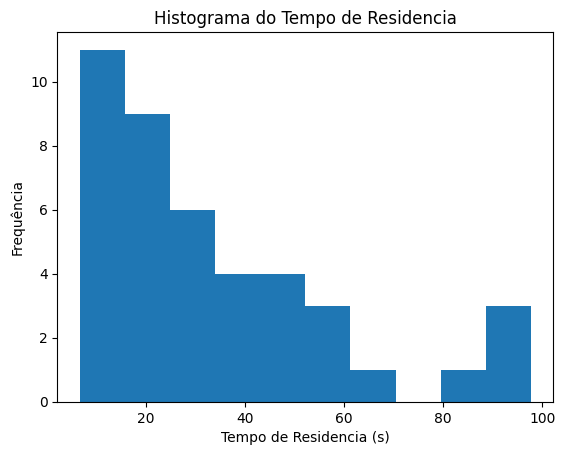

In [224]:
plt.figure()
plt.hist(tempos,10)
plt.xlabel("Tempo de Residencia (s)")
plt.ylabel("Frequência")
plt.title("Histograma do Tempo de Residencia")
plt.show()

In [225]:
import pickle
with open('/content/drive/My Drive/streamlines.pickle', 'wb') as f:
    pickle.dump(streamlines, f)

with open('/content/drive/My Drive/interpolator.pickle', 'wb') as f:
    pickle.dump(interpolator, f)

In [192]:
import pickle
drive_path = ""
with open('interpolator.pickle', 'wb') as f:
    pickle.dump(interpolator, f)

(272, 3)

In [168]:
np.array(streamlines[1]).T.shape

(4335, 3)

In [189]:
modv

[np.float64(0.24122628804195467),
 np.float64(0.04590414036957071),
 np.float64(0.05708895379518664),
 np.float64(0.05460880238044041),
 np.float64(0.06049871171798366),
 np.float64(0.06587232177998649),
 np.float64(0.07059560178345459),
 np.float64(0.0663915165569591),
 np.float64(0.07464090058609711),
 np.float64(0.05844189033013087),
 np.float64(0.06073496375138613),
 np.float64(0.06188808070247872),
 np.float64(0.06448936074843056),
 np.float64(0.06520205778089587),
 np.float64(0.06627990637261533)]

In [213]:
tempos = RTD(streamlines, modv)

In [184]:
modv.shape

(29600, 3)

In [179]:
lista = np.array([0,1])
lista[0] = np.array([0,1])
print(lista)

ValueError: setting an array element with a sequence.

In [147]:
 np.array(df[df['x-coordinate'] >= df['x-coordinate'].max()*0.9999][['x-coordinate','y-coordinate','z-coordinate']]).shape

(15, 3)

In [126]:
type(streamlines)

list

In [101]:
np.array(df[df['x-coordinate'] >= df['x-coordinate'].max()*0.999][['x-coordinate','y-coordinate','z-coordinate']]).shape

(110, 3)

In [81]:
np.transpose(streamlines[0])

array([[ 0.32989365,  0.01135485,  0.00454936],
       [ 0.31980514,  0.01129742,  0.00457245],
       [ 0.30327694,  0.01127893,  0.00461989],
       ...,
       [-0.03597382,  0.28932241,  0.00525313],
       [-0.03597382,  0.28932241,  0.00525313],
       [-0.03597382,  0.28932241,  0.00525313]])

In [45]:
transpose = np.transpose(streamlines[0])
vel = np.zeros_like(transpose)
for j in range(len(transpose)):
  vel[j] = interpolator(transpose[j][0],transpose[j][1],transpose[j][2])
print(vel)


[[-3.43415337e+00 -6.38601864e-02  2.10052893e-02]
 [-1.43484953e+00 -1.08126579e-02  4.01647211e-03]
 [-1.69155710e+00  3.09240383e-04 -3.92329674e-03]
 ...
 [            nan             nan             nan]
 [            nan             nan             nan]
 [            nan             nan             nan]]


[[6847    0]
 [6847    1]
 [6847    2]
 ...
 [9999    0]
 [9999    1]
 [9999    2]]


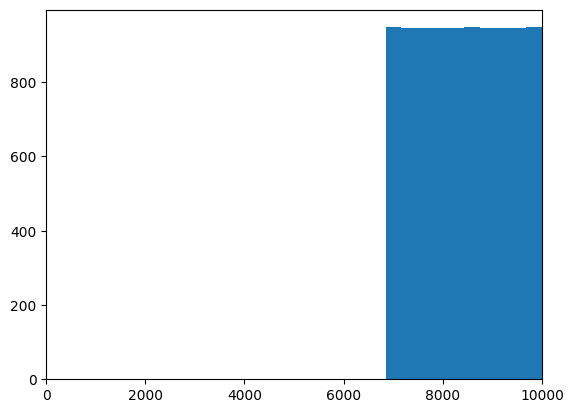

In [58]:
indices_nan = np.argwhere(np.isnan(vel))
print(indices_nan)
plt.hist(np.transpose(indices_nan)[0],10)
plt.xlim(0,10000)
plt.show()

In [38]:
transpose[0]

array([0.32989365, 0.01135485, 0.00454936])

In [91]:
modv = recreate_vel_field(interpolator, streamlines)
tempos = RTD(streamlines, modv)

TypeError: only integer scalar arrays can be converted to a scalar index

In [108]:
tempos = RTD(streamlines, modv)

In [114]:
modv

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,  7.83741315,         nan,
               nan,         nan, 14.61542765,         nan,         nan,
               nan, 15.10367202,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,  8.10172118,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan, 13.13991113,      

In [109]:
tempos.shape

(59994,)

In [18]:
v = np.array([1,2,3])
print(np.sqrt(np.sum(v**2)))

3.7416573867739413


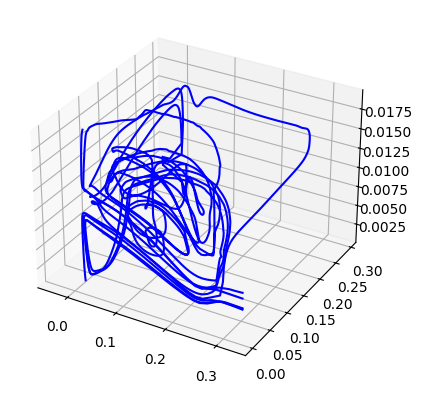

In [7]:
plot_streamlines(streamlines[80:85])

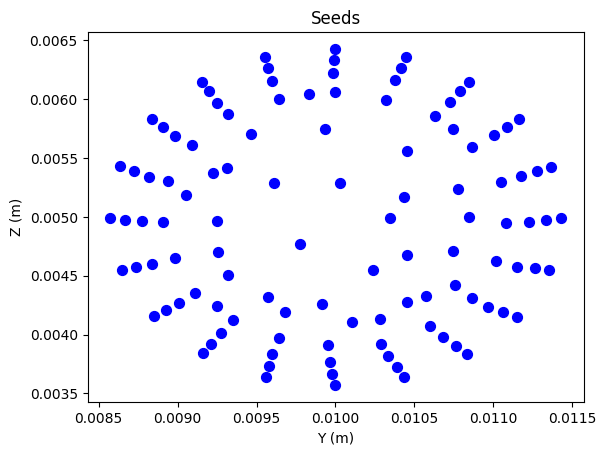

In [119]:
plt.figure()
plt.scatter(a[:,1],a[:,2],s=50,color="blue")
plt.xlabel("Y (m)")
plt.ylabel("Z (m)")
plt.title("Seeds")
#plt.xlim(0.3295,0.330)
#plt.ylim(0.0080,0.012)
plt.show()

In [ ]:
vel_field = recreate_vel_field(interpolator,streamlines)

In [73]:
d = 3e-3 #diametro do inlet
r = d/2 #raio metade do diâmetro
V = 6e-3 #volume 16L = 16e-3m^3
dt = 3600 # 1h = 3600s
Z = V/dt #vazâo
A = np.pi*r**2 #área da seção transversal
v = Z/A #velocidade do fluido na seção
print(v)

0.23578510087688198
